# Curve Fitting via Gradient Descent
This notebook walks through fitting a data to a model using **gradient descent**, breaking down the optimization problem step by step.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. The principles of curve fitting

Suppose we observe the flight of a cannon ball. It *should* be a parabola (a quadratic function), but our observations will have some noise.

In [2]:
def f(x, a, b):
    return a * x*x + b * x

Plotting the true curve

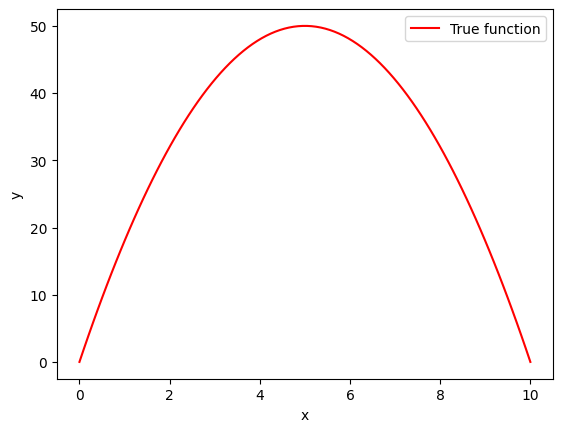

In [3]:
# True parameters
a_true, b_true = -2, 20
x = np.linspace(0, 10, 100)
y_true = f(x, a_true, b_true)

# Plot data
plt.plot(x, y_true, 'r-', label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

We can simulate some *noisy* data.

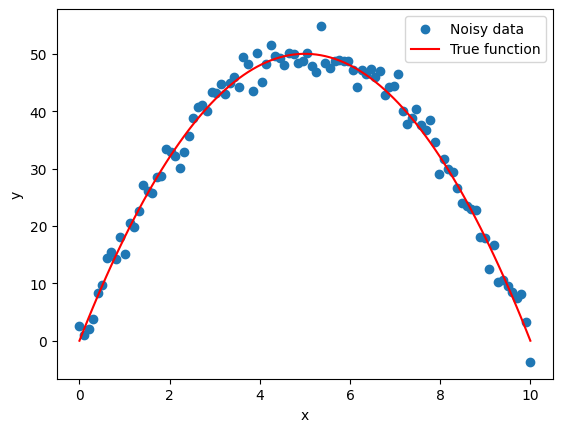

In [4]:
y_noisy = y_true + 2 * np.random.normal(size=x.size)

# Plot data
plt.scatter(x, y_noisy, label='Noisy data')
plt.plot(x, y_true, 'r-', label='True function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## 2. Measuring the error

What if we *don't* know the parameters $a$, $b$, and $c$? If we only have the data, how would we estimate the parameters?

Here is some real data from an observation.

In [5]:
y_real = np.array([ 2.36940577,  1.91256656,  3.29100004,  7.37237899,  8.18812265,
       18.11820761, 14.32964108, 23.45234193, 23.62329705, 30.8287573 ,
       26.80806497, 32.79398541, 35.06553443, 32.21923115, 39.24730387,
       42.92070059, 37.44160446, 46.44210828, 47.98489458, 50.6389694 ,
       53.82037364, 51.7647055 , 56.38908139, 56.26206115, 61.48547156,
       59.12983318, 61.26146892, 61.38177205, 61.7767669 , 67.62397392,
       69.1165745 , 68.00363628, 68.06124047, 66.05407344, 74.01905039,
       72.48996972, 77.38943085, 74.95610992, 71.69048994, 76.73277233,
       75.61839857, 75.18028164, 80.42250882, 78.57339426, 74.52704359,
       74.43486386, 82.60185162, 80.63046288, 79.27165332, 83.2890151 ,
       78.7393532 , 77.31638276, 76.05766149, 79.93963762, 85.7438112 ,
       78.3924083 , 75.06743955, 73.37798833, 80.24202993, 77.18560786,
       78.01280817, 78.06876329, 73.34550463, 72.32834926, 75.91838852,
       76.06033239, 73.46894369, 70.89037719, 69.35203876, 69.2537387 ,
       64.88669121, 61.9744727 , 66.14014532, 61.41478708, 62.08014846,
       59.97290679, 55.71001107, 55.72145555, 55.60052885, 51.0761939 ,
       48.45070483, 46.66118886, 45.4664427 , 49.08572602, 41.67735713,
       42.42097927, 37.24459493, 33.91618618, 29.18840866, 27.44201465,
       28.78153111, 27.63522533, 21.24672748, 18.50438048, 10.3768495 ,
       11.26647595, 11.80014487,  5.91476614,  1.61126693,  1.5332323 ])

### Activity 1

**Play** with the parameters `a_guess` and `b_guess` belows to try to find a good fit.

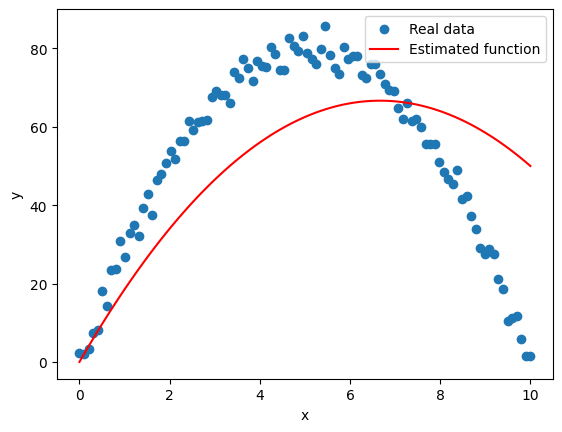

In [6]:
# Guess parameters. Change these!!
a_guess, b_guess = -1.5, 20
y_guess = f(x, a_guess, b_guess)


plt.scatter(x, y_real, label='Real data')
plt.plot(x, y_guess, 'r-', label='Estimated function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## 2. The Optimization Problem
We want to find parameters $(a, b)$ that minimize the **sum of squared errors**:

$$
J(a, b) = \frac{1}{2n} \sum_{i=1}^n (y_i - f(x_i; a, b))^2.
$$

In [7]:
def J(x, y, params):
    a, b = params
    n = x.size
    residuals = y - f(x, a, b)
    return (residuals**2).sum() / (2*n)

### Activity 2

Play with the values `a_guess` and `b_guess` below to try to minimise $J$.

In [8]:
a_guess, b_guess = -2, 30
J(x,y_real, (a_guess, b_guess))

918.0307945127761

## 3. Gradient Descent
Gradient descent is a general method for numerically finding the minimal value of a function of many variables.

**Idea** if you're standing on a hill and want to find the bottom of the hill, walk in the steepest downward direction.

iteratively updates parameters in the direction that **reduces** the cost. The update rule for each parameter $\theta_j$ is:

$$
\theta_j \leftarrow \theta_j - \alpha \frac{\partial J}{\partial \theta_j},
$$

where:
- $\alpha$ is the **learning rate** (step size).
- $\frac{\partial J}{\partial \theta_j}$ is the gradient of the cost w.r.t. $\theta_j$.

For our model $f(x; a,b) = ax^2 + bx$, the partial derivatives are:
$$
\frac{\partial J}{\partial a} = \frac{1}{n} \sum (y_i - f_i) x_i^2,
$$

$$
\frac{\partial J}{\partial b} = \frac{1}{n} \sum (y_i - f_i) x_i.
$$

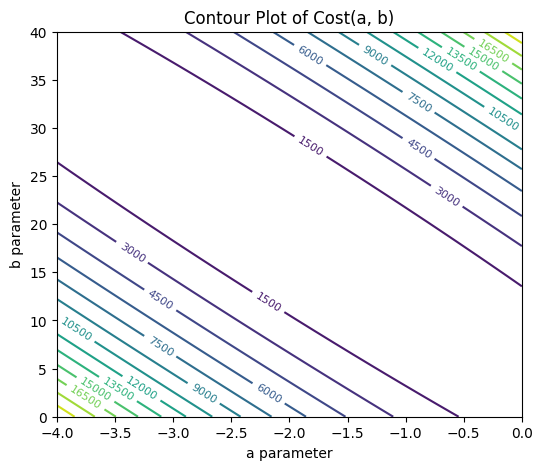

In [9]:
a_vals = np.linspace(-4, 0, 100)   # adjust range as needed
b_vals = np.linspace(0, 40, 100)   # adjust range as needed
A, B = np.meshgrid(a_vals, b_vals)

# 4) Compute the cost on the grid
Cost = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        Cost[i, j] = J(x, y_true, (A[i, j], B[i, j]))

# 5) Plot the contour
plt.figure(figsize=(6,5))
CS = plt.contour(A, B, Cost, levels=15)
plt.clabel(CS, inline=True, fontsize=8)
plt.xlabel('a parameter')
plt.ylabel('b parameter')
plt.title('Contour Plot of Cost(a, b)')
plt.show()

## 4. Implementing Gradient Descent
Let's code gradient descent to fit the parameters. We'll track the cost over iterations and inspect convergence.

In [10]:
def compute_gradient(x, y, params):
    a, b = params
    m = x.size
    y_pred = f(x, a, b)
    residuals = y - y_pred
    # gradients
    da = -np.sum(residuals * (x*x)) / m
    db = -np.sum(residuals * x) / m
    return np.array([da, db])

In [11]:
compute_gradient(x, y_true, (-1, 10))

array([-494.91582835,  -82.49158249])

In [12]:
# Initialize parameters
params = np.array([-1.0, 20])  # [a, b]
alpha = 0.0001   # learning rate
iterations = 200

cost_history = []
for i in range(iterations):
    grads = compute_gradient(x, y_real, params)
    params = params - alpha * grads
    cost_history.append(J(x, y_noisy, params))

a_gd, b_gd = params
print(f"After GD: a={a_gd:.3f}, b={b_gd:.3f}")

After GD: a=-1.752, b=20.396


## 5. Visualizing Convergence and Fit
Let's plot the cost function over iterations and compare the fitted curve to the data.

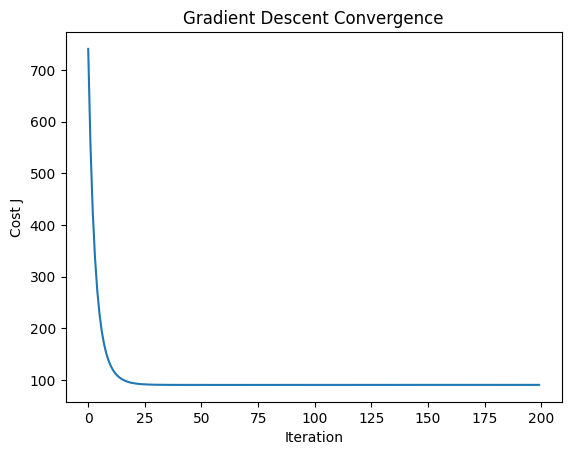

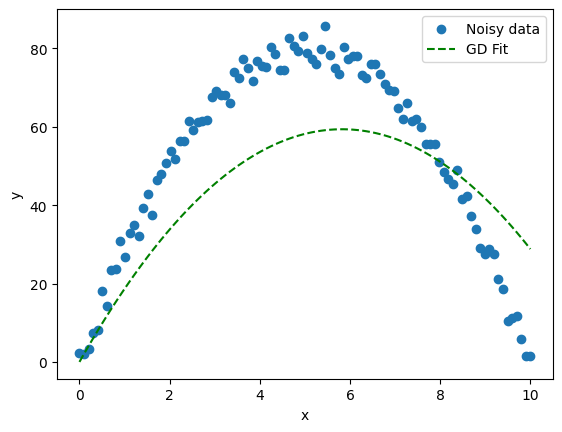

In [13]:
# Plot cost history
plt.figure()
plt.plot(cost_history)
plt.xlabel('Iteration')
plt.ylabel('Cost J')
plt.title('Gradient Descent Convergence')

# Plot fitted curve
plt.figure()
plt.scatter(x, y_real, label='Noisy data')
y_fit_gd = f(x, a_gd, b_gd)
plt.plot(x, y_fit_gd, 'g--', label='GD Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## 6. Discussion
- You can see how the cost decreases over iterations when the learning rate is appropriate.
- Too large a learning rate can cause divergence; too small makes convergence slow.
- SciPy's `curve_fit` uses more advanced methods (Levenberg–Marquardt) for faster, more reliable fitting.

Feel free to experiment with different learning rates, number of iterations, and models!